<a href="https://colab.research.google.com/github/ThiagoMartinsThome/Time_Series/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import output
!pip install cesium
output.clear()

In [18]:
!git clone 'https://github.com/PracticalTimeSeriesAnalysis/BookRepo'

Cloning into 'BookRepo'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 60 (delta 15), reused 51 (delta 9), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [77]:
!pwd
%ls
%cd BookRepo/
#%cd '/content/BookRepo'# Set the working directory

/content
BookRepo/  sample_data/
/content/BookRepo


In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [0]:
import cesium
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from cesium import datasets
from cesium import featurize as ft

import scipy
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [29]:
print(cesium.__version__)
print(xgb.__version__)
print(scipy.__version__)
print(sklearn.__version__)

0.9.12
0.90
1.4.1
0.22.2.post1


## Load data and generate some features of interest

In [30]:
eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


In [31]:
type(eeg)

dict

In [32]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

### Visually inspect

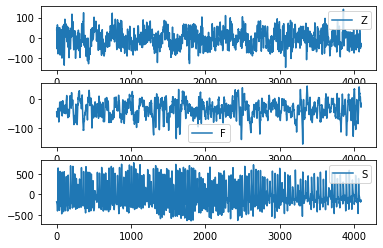

In [33]:
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

In [34]:
type(eeg["measurements"][0])

numpy.ndarray

In [35]:
type(eeg)

dict

In [36]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [37]:
type(eeg['measurements'])

list

In [38]:
len(eeg['measurements'])

500

In [39]:
eeg['measurements'][0].shape

(4097,)

## Generate the features

In [0]:
# from cesium import featurize as ft
# features_to_use = ["amplitude",
#                    "percent_beyond_1_std",
#                    "percent_close_to_median",
#                   "skew",
#                   "max_slope"]
# fset_cesium = ft.featurize_time_series(times=eeg["times"],
#                                               values=eeg["measurements"],
#                                               errors=None,
#                                               features_to_use=features_to_use,
#                                              scheduler = None)

In [0]:
fset_cesium = pd.read_csv("Ch09/full_eeg_data_features.csv", header = [0, 1])

In [79]:
fset_cesium.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
,channel,0,0,0,0,0
0,0,143.5,0.327313,0.505004,0.032805,11107.796610
1,1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,3,171.5,0.300952,0.541128,0.063678,17008.813559
4,4,170.0,0.305101,0.566268,0.142753,13016.949153


In [0]:
# fset_cesium.to_csv("full_eeg_data_features.csv")

In [81]:
fset_cesium.shape

(500, 6)

## Exercise: validate/calculate these features by hand
#### look up feature definitions here: http://cesium-ml.org/docs/feature_table.html
confirm the values by hand coding these features for the first EEG measurement
(that is eeg["measurements"][0])

In [0]:
ex = eeg["measurements"][0]

In [0]:
ex_mean = np.mean(ex)
ex_std  = np.std(ex)

In [84]:
# amplitude
(np.max(ex) - np.min(ex)) / 2

143.5

In [85]:
 
siz = len(ex)
ll = ex_mean - ex_std
ul = ex_mean + ex_std

quals = [i for i in range(siz) if ex[i] < ll or ex[i] > ul]
len(quals)/len(ex)

0.3273126678057115

In [86]:
# percent_close_to_median
# Percentage of values within window_frac*(max(x)-min(x)) of median.
# find the source code here:
# https://github.com/cesium-ml/cesium/blob/master/cesium/features/common_functions.py
# window frac = 0.1
window = 0.1 * (np.max(ex) - np.min(ex))
np.where(np.abs(ex_mean - ex) < window)[0].shape[0] / ex.shape[0]

0.5050036612155235

0.03280499636078603


(array([  10.,   57.,  276.,  730., 1048., 1042.,  621.,  263.,   42.,
           8.]),
 array([-146. , -117.3,  -88.6,  -59.9,  -31.2,   -2.5,   26.2,   54.9,
          83.6,  112.3,  141. ]),
 <a list of 10 Patch objects>)

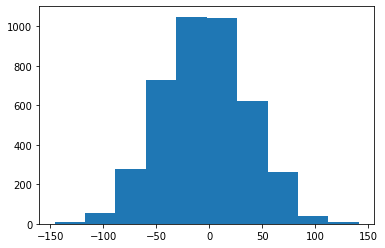

In [87]:
## skew
print(skew(ex))
plt.hist(ex)

In [88]:
## max slope
## again check definition : https://github.com/cesium-ml/cesium/blob/master/cesium/features/common_functions.py
times = eeg["times"][0]
np.max(np.abs(np.diff(ex)/np.diff(times)))

11107.796610166752

(array([311.,  85.,  30.,  19.,   8.,  13.,   7.,  14.,   7.,   6.]),
 array([  63. ,  241.5,  420. ,  598.5,  777. ,  955.5, 1134. , 1312.5,
        1491. , 1669.5, 1848. ]),
 <a list of 10 Patch objects>)

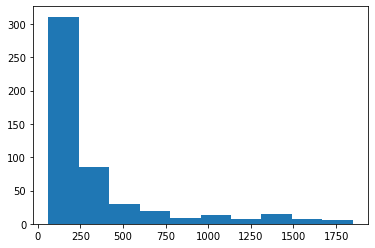

In [89]:
plt.hist(fset_cesium.iloc[:, 1])

In [0]:
fset_cesium['classes'] = eeg['classes']

In [0]:
fset_cesium.columns = fset_cesium.columns.droplevel(-1)

classes
F    AxesSubplot(0.125,0.125;0.775x0.755)
N    AxesSubplot(0.125,0.125;0.775x0.755)
O    AxesSubplot(0.125,0.125;0.775x0.755)
S    AxesSubplot(0.125,0.125;0.775x0.755)
Z    AxesSubplot(0.125,0.125;0.775x0.755)
Name: amplitude, dtype: object

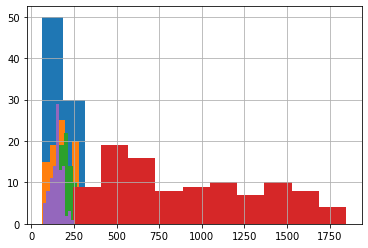

In [92]:
fset_cesium.groupby('classes')['amplitude'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac23323320>,
      dtype=object)

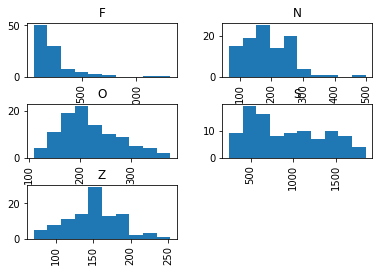

In [93]:
fset_cesium['amplitude'].hist(by=fset_cesium['classes'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac22e73a20>,
      dtype=object)

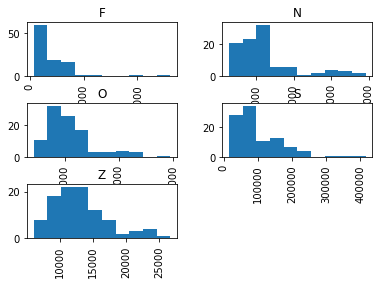

In [94]:
fset_cesium['max_slope'].hist(by=fset_cesium['classes'])

## Prepare data for training

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
     fset_cesium.iloc[:, 1:6].values, eeg["classes"], random_state=21)

## Try a random forest with these features

In [0]:
clf = RandomForestClassifier(n_estimators=10, max_depth=3,
                              random_state=21)

In [97]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [98]:
clf.score(X_train, y_train)

0.6266666666666667

In [99]:
clf.score(X_test, y_test)

0.616

In [100]:
np.unique(y_test, return_counts=True)

(array(['F', 'N', 'O', 'S', 'Z'], dtype='<U1'), array([20, 29, 21, 25, 30]))

In [101]:
y_test

array(['O', 'S', 'N', 'F', 'S', 'S', 'Z', 'S', 'O', 'Z', 'F', 'O', 'S',
       'F', 'Z', 'N', 'Z', 'O', 'Z', 'Z', 'S', 'F', 'O', 'N', 'F', 'F',
       'Z', 'N', 'Z', 'N', 'S', 'Z', 'O', 'O', 'S', 'S', 'N', 'S', 'N',
       'S', 'N', 'O', 'N', 'S', 'Z', 'N', 'O', 'Z', 'Z', 'S', 'O', 'Z',
       'F', 'F', 'S', 'Z', 'N', 'O', 'N', 'F', 'Z', 'Z', 'N', 'Z', 'F',
       'Z', 'N', 'F', 'O', 'N', 'N', 'Z', 'N', 'O', 'N', 'F', 'O', 'F',
       'F', 'Z', 'S', 'N', 'Z', 'N', 'O', 'N', 'S', 'N', 'S', 'O', 'O',
       'S', 'O', 'N', 'N', 'S', 'N', 'S', 'Z', 'Z', 'S', 'S', 'O', 'F',
       'S', 'F', 'F', 'Z', 'F', 'Z', 'O', 'O', 'S', 'Z', 'Z', 'F', 'N',
       'Z', 'Z', 'F', 'S', 'N', 'Z', 'N', 'N'], dtype='<U1')

In [102]:
y_test.shape

(125,)

In [103]:
y_train.shape

(375,)

## Try XGBoost with these features

In [104]:
model = xgb.XGBClassifier(n_estimators=10, max_depth=3,
                              random_state=21)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=21,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [105]:
model.score(X_test, y_test)

0.648

In [106]:
model.score(X_train, y_train)

0.752

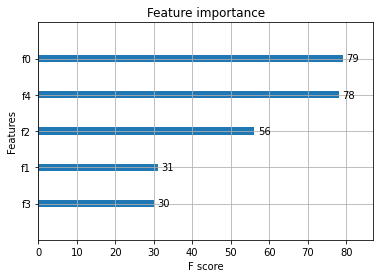

In [107]:
xgb.plot_importance(model)

## Time Series Forecasting with Decision Trees

In [110]:
%ls

Ch02/  Ch03/  Ch04/  Ch07/  Ch09/  Ch10/  Ch14/  README.md


In [0]:
#ap = pd.read_csv("Ch02/data/AirPassengers.csv", parse_dates=[0])
ap = pd.read_csv("Ch02/data/AirPassengers.csv", parse_dates=[0], names=['Month', 'Passengers'])

In [0]:
ap.set_index('Month', inplace=True)

In [119]:
ap.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


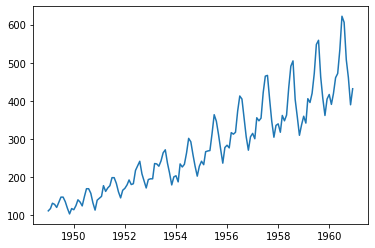

In [120]:
plt.plot(ap)

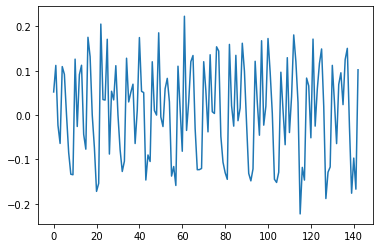

In [121]:
plt.plot(np.diff(np.log(ap.values[:, 0])))

In [0]:
ts = np.diff(np.log(ap.values[:, 0]))

## Exercise: now that we have 1 time series, how can we convert it to many samples?

In [0]:
NSTEPS = 12

In [124]:
ts.shape

(143,)

In [0]:
vals = np.hstack([np.expand_dims(np.array(ts, dtype = np.float32), axis = 1) for _ in range(NSTEPS )])

In [126]:
ts[0:NSTEPS]

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629373, -0.0257525 ])

In [127]:
vals.shape

(143, 12)

In [0]:
nrow = vals.shape[0]
for lag in range(1, vals.shape[1]):
    vals[:(nrow - lag),lag] = vals[lag:,lag]
    vals[(nrow - lag):, lag] = np.nan

In [129]:
vals

array([[ 0.05218575,  0.1121173 , -0.02298952, ..., -0.13473259,
         0.12629372, -0.0257525 ],
       [ 0.1121173 , -0.02298952, -0.06402186, ...,  0.12629372,
        -0.0257525 ,  0.09134978],
       [-0.02298952, -0.06402186,  0.10948423, ..., -0.0257525 ,
         0.09134978,  0.11247798],
       ...,
       [-0.0970834 , -0.1672513 ,  0.10227885, ...,         nan,
                nan,         nan],
       [-0.1672513 ,  0.10227885,         nan, ...,         nan,
                nan,         nan],
       [ 0.10227885,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

In [0]:
vals = vals[:(vals.shape[0] - NSTEPS + 1), :]

In [131]:
vals.shape

(132, 12)

In [132]:
vals[-1]

array([ 0.02919916, -0.06437866,  0.06916336,  0.09552712,  0.02358094,
        0.12528776,  0.15067334, -0.02606011, -0.17639855, -0.0970834 ,
       -0.1672513 ,  0.10227885], dtype=float32)

In [133]:
ts[-NSTEPS:]

array([ 0.02919915, -0.06437866,  0.06916336,  0.09552712,  0.02358094,
        0.12528776,  0.15067335, -0.02606011, -0.17639854, -0.0970834 ,
       -0.1672513 ,  0.10227885])

In [134]:
vals.shape

(132, 12)

## Exercise: now that we have the time series broken down into a set of samples, how to featurize?

In [0]:
measures = [vals[i][0:(NSTEPS - 1)] for i in range(vals.shape[0])]

In [0]:
times = [[j for j in range(NSTEPS - 1)] for i in range(vals.shape[0])]

In [137]:
measures[0]

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629372], dtype=float32)

In [138]:
len(measures[0])

11

In [0]:
features_to_use = [
                   "amplitude",
                   "percent_beyond_1_std",
                   "skew",
                   "max_slope",
                   "percent_amplitude"]
fset_ap = ft.featurize_time_series(times=times,
                                    values=measures,
                                    errors=None,
                                    features_to_use=features_to_use,
                                    scheduler = None)

In [0]:
fset_ap.columns = fset_ap.columns.droplevel(-1)

In [141]:
fset_ap.head()

feature,amplitude,percent_beyond_1_std,skew,max_slope,percent_amplitude
0,0.130513,0.454545,-0.155365,0.261026,0.132121
1,0.130513,0.545455,0.051772,0.261026,0.128461
2,0.130513,0.545455,0.037850,0.261026,0.128461
3,0.130513,0.454545,-0.192651,0.261026,0.132121
4,0.130513,0.454545,-0.233966,0.261026,0.132121


(array([15.,  7.,  5., 23., 26., 17.,  6.,  6., 16., 11.]),
 array([0.12786029, 0.1352786 , 0.14269691, 0.15011522, 0.15753352,
        0.16495183, 0.17237014, 0.17978845, 0.18720675, 0.19462506,
        0.20204337]),
 <a list of 10 Patch objects>)

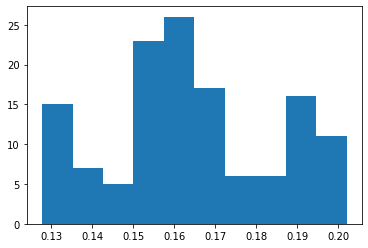

In [142]:
plt.hist(fset_ap.amplitude)

(array([16., 40., 35.,  4., 15.,  9.,  1.,  9.,  2.,  1.]),
 array([0.12414427, 0.14138614, 0.15862801, 0.17586988, 0.19311176,
        0.21035363, 0.2275955 , 0.24483737, 0.26207924, 0.27932111,
        0.29656298]),
 <a list of 10 Patch objects>)

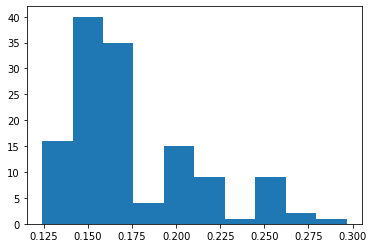

In [143]:
plt.hist(fset_ap.percent_amplitude)

(array([ 9., 11.,  8., 23., 26., 25., 18.,  9.,  2.,  1.]),
 array([-0.56547007, -0.45117751, -0.33688495, -0.22259239, -0.10829984,
         0.00599272,  0.12028528,  0.23457784,  0.3488704 ,  0.46316296,
         0.57745551]),
 <a list of 10 Patch objects>)

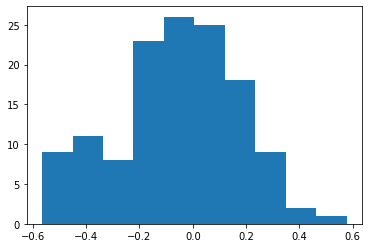

In [144]:
plt.hist(fset_ap['skew'])

## Exercise: can you fit an XGBRegressor to this problem? Let's use the first 100 'time series' as the training data

In [0]:
outcomes = vals[:, -1]

In [0]:
X_train, y_train = fset_ap.iloc[:100, :], outcomes[:100]
X_test, y_test   = fset_ap.iloc[100:, :], outcomes[100:]

In [147]:
X_train.shape

(100, 5)

In [0]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)

In [149]:
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[07:20:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.454853
[1]	validation_0-rmse:0.408914
[2]	validation_0-rmse:0.367291
[3]	validation_0-rmse:0.330652
[4]	validation_0-rmse:0.297609
[5]	validation_0-rmse:0.269572
[6]	validation_0-rmse:0.241831
[7]	validation_0-rmse:0.219749
[8]	validation_0-rmse:0.198331
[9]	validation_0-rmse:0.178537
[10]	validation_0-rmse:0.161809
[11]	validation_0-rmse:0.149125
[12]	validation_0-rmse:0.137653
[13]	validation_0-rmse:0.128714
[14]	validation_0-rmse:0.122771
[15]	validation_0-rmse:0.118241
[16]	validation_0-rmse:0.114619
[17]	validation_0-rmse:0.112702
[18]	validation_0-rmse:0.112149
[19]	validation_0-rmse:0.112382


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

### RMSE can be hard to digest .... How does the model perform?

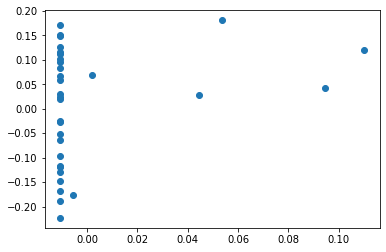

In [150]:
plt.scatter(model.predict(X_test), y_test)

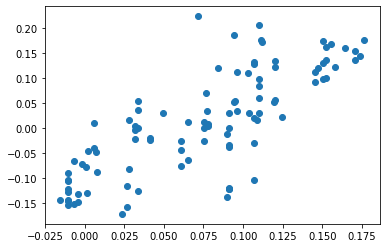

In [151]:
plt.scatter(model.predict(X_train), y_train)

In [152]:
pearsonr(model.predict(X_train), y_train)

(0.7763253592748394, 2.3452056738489926e-21)

In [153]:
pearsonr(model.predict(X_test), y_test)

(0.26575179862682674, 0.1415369090490501)

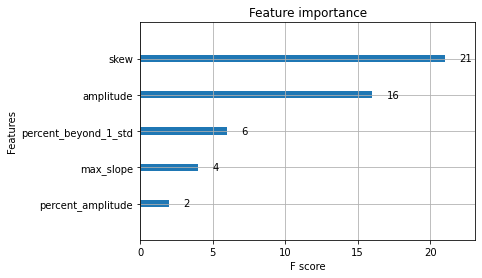

In [154]:
xgb.plot_importance(model)

### What went wrong? Let's revisit the feature set

In [155]:
fset_ap.head()

feature,amplitude,percent_beyond_1_std,skew,max_slope,percent_amplitude
0,0.130513,0.454545,-0.155365,0.261026,0.132121
1,0.130513,0.545455,0.051772,0.261026,0.128461
2,0.130513,0.545455,0.037850,0.261026,0.128461
3,0.130513,0.454545,-0.192651,0.261026,0.132121
4,0.130513,0.454545,-0.233966,0.261026,0.132121


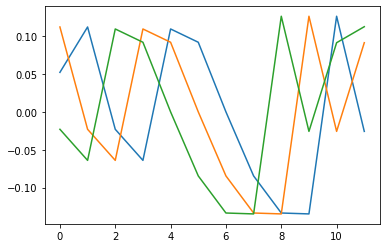

In [156]:
plt.plot(vals[0])
plt.plot(vals[1])
plt.plot(vals[2])

## We need to find a way to generate features that encode positional information

### now we will generate our own features

In [157]:
vals.shape

(132, 12)

In [0]:
feats = np.zeros( (vals.shape[0], 6), dtype = np.float32)
for i in range(vals.shape[0]):
    feats[i, 0] = np.where(vals[i] == np.max(vals[i]))[0][0]
    feats[i, 1] = np.where(vals[i] == np.min(vals[i]))[0][0]
    feats[i, 2] = feats[i, 0] - feats[i, 1]
    feats[i, 3] = np.max(vals[i][-3:])
    feats[i, 4] = vals[i][-1] - vals[i][-2]
    feats[i, 5] = vals[i][-1] - vals[i][-3]

In [159]:
feats[0:3]

array([[10.        ,  9.        ,  1.        ,  0.12629372, -0.15204622,
         0.10898009],
       [ 9.        ,  8.        ,  1.        ,  0.12629372,  0.11710228,
        -0.03494394],
       [ 8.        ,  7.        ,  1.        ,  0.11247798,  0.0211282 ,
         0.13823047]], dtype=float32)

### How do these look compared to the first set of features?

In [160]:
pd.DataFrame(feats[0:3])

,0,1,2,3,4,5
0,10.0,9.0,1.0,0.126294,-0.152046,0.108980
1,9.0,8.0,1.0,0.126294,0.117102,-0.034944
2,8.0,7.0,1.0,0.112478,0.021128,0.138230


In [0]:
X_train, y_train = feats[:100, :], outcomes[:100]
X_test, y_test   = feats[100:, :], outcomes[100:]

In [162]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[07:20:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.459744
[1]	validation_0-rmse:0.418616
[2]	validation_0-rmse:0.380625
[3]	validation_0-rmse:0.346577
[4]	validation_0-rmse:0.315931
[5]	validation_0-rmse:0.287931
[6]	validation_0-rmse:0.263988
[7]	validation_0-rmse:0.241361
[8]	validation_0-rmse:0.222136
[9]	validation_0-rmse:0.205052
[10]	validation_0-rmse:0.189806
[11]	validation_0-rmse:0.175841
[12]	validation_0-rmse:0.162495
[13]	validation_0-rmse:0.150479
[14]	validation_0-rmse:0.139907
[15]	validation_0-rmse:0.131403
[16]	validation_0-rmse:0.122909
[17]	validation_0-rmse:0.115215
[18]	validation_0-rmse:0.108389
[19]	validation_0-rmse:0.102514


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

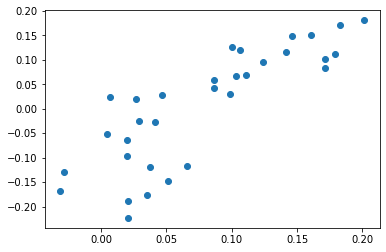

In [163]:
plt.scatter(model.predict(X_test), y_test)

In [164]:
print(pearsonr(model.predict(X_test), y_test))
print(spearmanr(model.predict(X_test), y_test))

(0.8295710199019659, 4.3988566454564714e-09)
SpearmanrResult(correlation=0.8506737877812696, pvalue=7.029762268431634e-10)


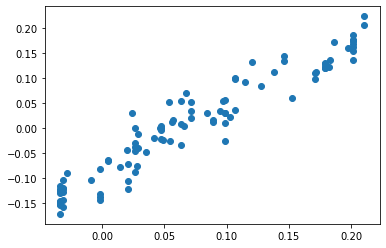

In [165]:
plt.scatter(model.predict(X_train), y_train)

In [166]:
print(pearsonr(model.predict(X_train), y_train))
print(spearmanr(model.predict(X_train), y_train))

(0.9574312130551085, 1.1011058590058442e-54)
SpearmanrResult(correlation=0.9608384510376272, pvalue=2.0044276644436398e-56)
